# What is this notebook about

This notebook builds upon the notebooks ``` spacenet6_masking.ipynb ``` and ``` spacenet6_resize.ipynb ```

``` spacenet6_masking.ipynb ``` is used to generate all the masks for all 3401 training images, using only the PAN images and geojson_buildings files. These masks will be the same regardless of the original data format, hence it is a run-once-and-forget

``` spacenet6_resize.ipynb ``` is used to resize images to the appropriate size and data format, depending on the output resolution wanted for training. Most research papers utilise a 256x256 resolution as a sufficient size for unet applications. This should be run before running this notebook to set up the files needed



This notebook is a failed attempt at image segmentation, following the guide found from https://www.youtube.com/watch?v=LvqzKr-dORQ&list=PLZsOBAyNTZwYuFfht61R0b-N1TNIX5_Vy, Python for Microscopists 

# Setup COLAB and imports

In [ ]:
''' Used to reference the root directory, for directory traversal '''
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = '/content/gdrive/My Drive/Colab Notebooks'

In [ ]:
! pip install rasterio

In [ ]:
import rasterio
from rasterio.plot import show, reshape_as_raster, reshape_as_image

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import os
import numpy as np
from pathlib import Path
from tqdm import tqdm 
import tensorflow as tf
import copy

# Global

In [ ]:
''' get the same random set every time '''
seed = 42
np.random.seed = seed


''' we will be resizing to this for the unet '''
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
DTYPE_SRC = np.uint16
DTYPE_TARGET = np.uint8


''' setting the amount of data we want to use '''
SIZE_TRAIN = 400    # folder has 3401
SIZE_TEST = 40      # folder has 401

In [ ]:
''' change in accordance to the image type and dimensions '''
COMBI = 'psrgb_256x256_uint16'


''' Get the directories for this combination '''
PATH_DATA = Path(root_dir + '/spacenet6/spacenet6_data/' + COMBI)
PATH_TRAIN = PATH_DATA/'train'
PATH_MASK = PATH_DATA/'mask'
PATH_TEST = PATH_DATA/'test'

# Helper functions

#### Available functions
*   cast_dtype(raster)
*   save_np_2d(array, fname)

### Change the dtype of a raster file to target dtype

In [ ]:
def cast_dtype(raster, dtype):
  raster = tf.dtypes.cast(raster, dtype)
  raster = raster.numpy()
  img = reshape_as_image(raster)
  return img

#### Save a 2D numpy array to text file

In [ ]:
def save_np_2d(array, fname):
  fname = fname + '.txt'
  np.savetxt(PATH_DATA/fname, array, fmt="%s")
  print('saved')

# Unet

### Get prepped data ready

In [ ]:
# Grab the filenames from files that were prepared

''' Get all, sort, then take a subset and make a copy '''
_train_ids = next(os.walk(PATH_TRAIN))[2]
_mask_ids = next(os.walk(PATH_MASK))[2]
_test_ids = next(os.walk(PATH_TEST))[2]

_train_ids.sort()
_mask_ids.sort()
_test_ids.sort()

train_ids = copy.deepcopy(_train_ids[:SIZE_TRAIN])
mask_ids = copy.deepcopy(_mask_ids[:SIZE_TRAIN])
test_ids = copy.deepcopy(_test_ids[:SIZE_TEST]) 

print(len(train_ids))
print(train_ids[:3])
print(len(mask_ids))
print(mask_ids[:3])
print(len(test_ids))
print(test_ids[:3])

400
['SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8679.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8681.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8683.tif']
400
['SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.tif', 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8681.tif', 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8683.tif']
40
['SN6_Train_AOI_11_Rotterdam_PS-RGB_20190823141628_20190823141922_tile_8743.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190823141628_20190823141922_tile_8744.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190823142111_20190823142355_tile_3933.tif']


In [ ]:
# x: image data    y: mask data
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=DTYPE_TARGET)
Y_train = np.zeros((len(mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=DTYPE_TARGET)
# no Y_test since no mask given for test images

print('X_train', X_train.shape, X_train.dtype)
print('Y_train', Y_train.shape, Y_train.dtype)
print('X_test', X_test.shape, X_test.dtype)

X_train (400, 256, 256, 3) uint8
Y_train (400, 256, 256, 1) bool
X_test (40, 256, 256, 3) uint8


In [ ]:
''' format images into uint8 format and save into array '''

print('formatting training images')
for n, id in tqdm(enumerate(train_ids), total=len(train_ids), position=0, leave=True):
  X_train[n] = cast_dtype(rasterio.open(PATH_TRAIN/train_ids[n]).read(), DTYPE_TARGET)
print('Finished formatting training images')

print('formatting mask images')
for n, id in tqdm(enumerate(mask_ids), total=len(mask_ids), position=0, leave=True):
  Y_train[n] = cast_dtype(rasterio.open(PATH_MASK/mask_ids[n]).read(), np.bool)
print('Finished formatting mask images')

print('formatting test images')
for n, id in tqdm(enumerate(test_ids), total=len(test_ids), position=0, leave=True):
  X_test[n] = cast_dtype(rasterio.open(PATH_TEST/test_ids[n]).read(), DTYPE_TARGET)
print('Finished formatting test images')

  1%|          | 3/400 [00:00<00:16, 24.26it/s]

formatting training images


  0%|          | 0/400 [00:00<?, ?it/s]

Finished formatting training images
formatting mask images


  0%|          | 0/40 [00:00<?, ?it/s]

Finished formatting mask images
formatting test images


100%|██████████| 40/40 [00:26<00:00,  1.49it/s]

Finished formatting test images


index: 12
Training set


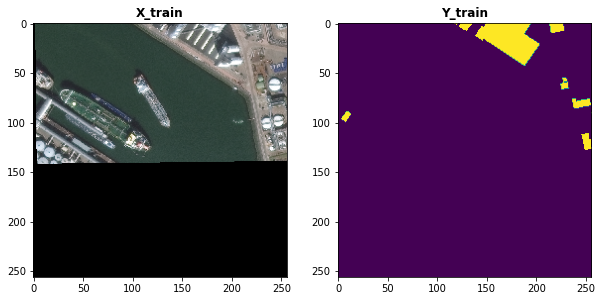

index: 398
Training set


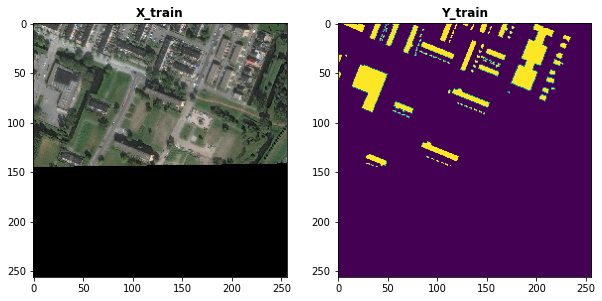

index: 8
Test set


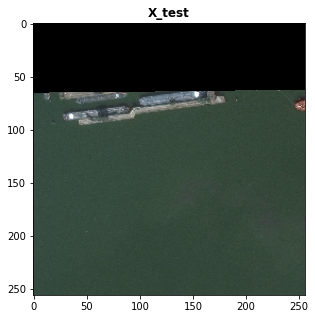

index: 6
Test set


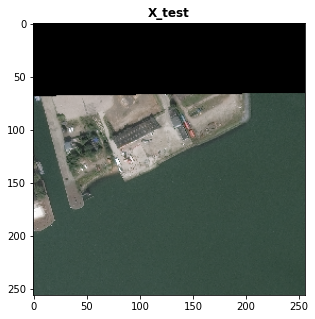

In [ ]:
ix = np.random.randint(0, len(X_train))
print("index: {}".format(ix))
print("Training set")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
show(reshape_as_raster(X_train[ix]), ax=ax1, title='X_train')
show(reshape_as_raster(Y_train[ix]), ax=ax2, title='Y_train')
plt.show()



ix = np.random.randint(0, len(X_train))
print("index: {}".format(ix))
print("Training set")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
show(reshape_as_raster(X_train[ix]), ax=ax1, title='X_train')
show(reshape_as_raster(Y_train[ix]), ax=ax2, title='Y_train')
plt.show()



ix = np.random.randint(0, len(X_test))
print("index: {}".format(ix))
print("Test set")

fig, (ax1) = plt.subplots(1, figsize=(10,5))
show(reshape_as_raster(X_test[ix]), ax=ax1, title='X_test')
plt.show()



ix = np.random.randint(0, len(X_test))
print("index: {}".format(ix))
print("Test set")

fig, (ax1) = plt.subplots(1, figsize=(10,5))
show(reshape_as_raster(X_test[ix]), ax=ax1, title='X_test')
plt.show()

### Build the unet model

In [ ]:
from keras import backend as K

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

Using TensorFlow backend.


In [ ]:
# Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c5)

c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# Expansive path 
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
 
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1], axis=3)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
# model.compile(optimizer='adam', metrics=['accuracy'], loss=[focal_loss()])
model.summary()


# # Build the model
# inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# # Contraction path
# c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
# c1 = tf.keras.layers.Dropout(0.1)(c1)
# c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
# p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
# c2 = tf.keras.layers.Dropout(0.1)(c2)
# c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
# p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
# c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
# c3 = tf.keras.layers.Dropout(0.2)(c3)
# c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
# p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
# c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
# c4 = tf.keras.layers.Dropout(0.2)(c4)
# c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
# p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

# c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
# c5 = tf.keras.layers.Dropout(0.2)(c5)
# c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
# p5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c5)

# c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
# c6 = tf.keras.layers.Dropout(0.2)(c6)
# c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
# p6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c6)

# c7 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p6)
# c7 = tf.keras.layers.Dropout(0.2)(c7)
# c7 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
# p7 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c7)
 
# c8 = tf.keras.layers.Conv2D(2048, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p7)
# c8 = tf.keras.layers.Dropout(0.3)(c8)
# c8 = tf.keras.layers.Conv2D(2048, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# # Expansive path 
# u9 = tf.keras.layers.Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(c8)
# u9 = tf.keras.layers.concatenate([u9, c7])
# c9 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
# c9 = tf.keras.layers.Dropout(0.2)(c9)
# c9 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
# u10 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c9)
# u10 = tf.keras.layers.concatenate([u10, c6])
# c10 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
# c10 = tf.keras.layers.Dropout(0.2)(c10)
# c10 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
 
# u11 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c10)
# u11 = tf.keras.layers.concatenate([u11, c5])
# c11 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
# c11 = tf.keras.layers.Dropout(0.1)(c11)
# c11 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
 
# u12 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c11)
# u12 = tf.keras.layers.concatenate([u12, c4], axis=3)
# c12 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u12)
# c12 = tf.keras.layers.Dropout(0.1)(c12)
# c12 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c12)
 
# u13 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c12)
# u13 = tf.keras.layers.concatenate([u13, c3], axis=3)
# c13 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u13)
# c13 = tf.keras.layers.Dropout(0.1)(c13)
# c13 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c13)

# u14 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c13)
# u14 = tf.keras.layers.concatenate([u14, c2], axis=3)
# c14 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u14)
# c14 = tf.keras.layers.Dropout(0.1)(c14)
# c14 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c14)

# u15 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c14)
# u15 = tf.keras.layers.concatenate([u15, c1], axis=3)
# c15 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u15)
# c15 = tf.keras.layers.Dropout(0.1)(c15)
# c15 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c15)


# outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c15)
 
# model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# # model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
# model.compile(optimizer='adam', metrics=['accuracy'], loss=[focal_loss()])
# model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
# Model checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_spacenet6.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]

# results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=5, callbacks=callbacks)

model.save_weights('weights for spacenet6.h5')

Epoch 1/5
23/23 [==============================] - 280s 12s/step - loss: 0.5640 - accuracy: 0.8802 - val_loss: 0.4095 - val_accuracy: 0.9360
Epoch 2/5
23/23 [==============================] - 273s 12s/step - loss: 0.3160 - accuracy: 0.9378 - val_loss: 0.2275 - val_accuracy: 0.9360
Epoch 3/5
23/23 [==============================] - 277s 12s/step - loss: 0.2114 - accuracy: 0.9380 - val_loss: 0.1903 - val_accuracy: 0.9360
Epoch 4/5
23/23 [==============================] - 276s 12s/step - loss: 0.1810 - accuracy: 0.9380 - val_loss: 0.2153 - val_accuracy: 0.9360
Epoch 5/5
23/23 [==============================] - 285s 12s/step - loss: 0.1707 - accuracy: 0.9380 - val_loss: 0.1874 - val_accuracy: 0.9360


In [ ]:
# split train, val 90-10
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

2/2 [==============================] - 1s 691ms/step


### Check results

index: 146
Training set


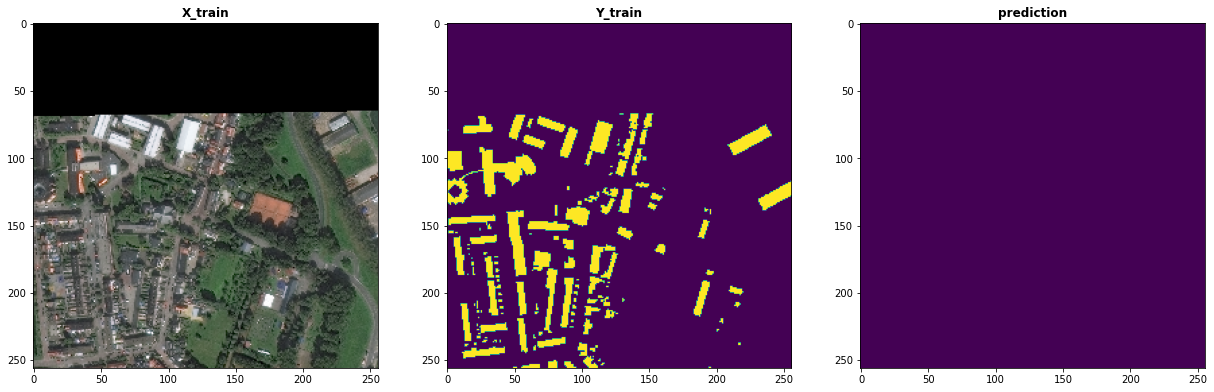

In [ ]:
# Perform a sanity check on some random training samples
ix = np.random.randint(0, len(preds_train_t))
print("index: {}".format(ix))
print("Training set")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,7))
show(reshape_as_raster(X_train[ix]), ax=ax1, title='X_train')
show(reshape_as_raster(Y_train[ix]), ax=ax2, title='Y_train')
show(reshape_as_raster(preds_train_t[ix]), ax=ax3, title='prediction')
plt.show()

index: 11
Validation set


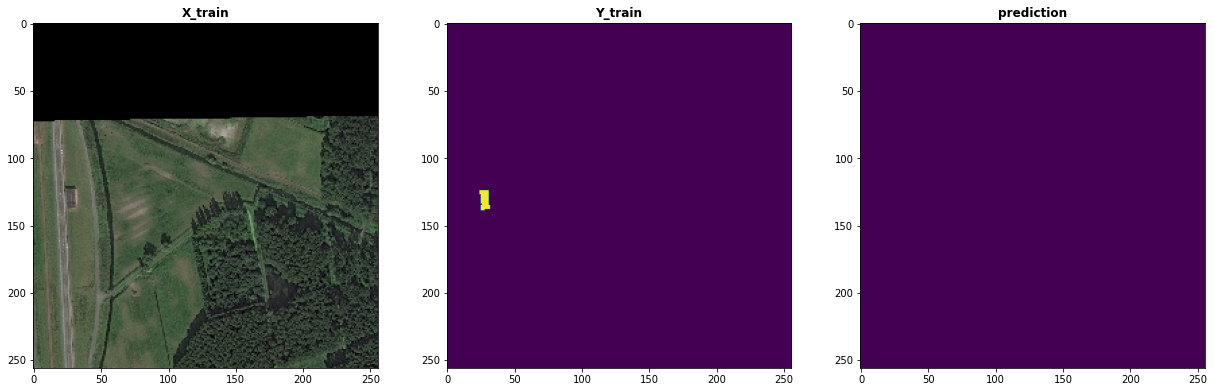

In [ ]:
# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(preds_val_t))
print("index: {}".format(ix))
print("Validation set")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,7))
show(reshape_as_raster(X_train[int(X_train.shape[0]*0.9):][ix]), ax=ax1, title='X_train')
show(reshape_as_raster(Y_train[int(Y_train.shape[0]*0.9):][ix]), ax=ax2, title='Y_train')
show(reshape_as_raster(preds_val_t[ix]), ax=ax3, title='prediction')
plt.show()

index: 11
Test set


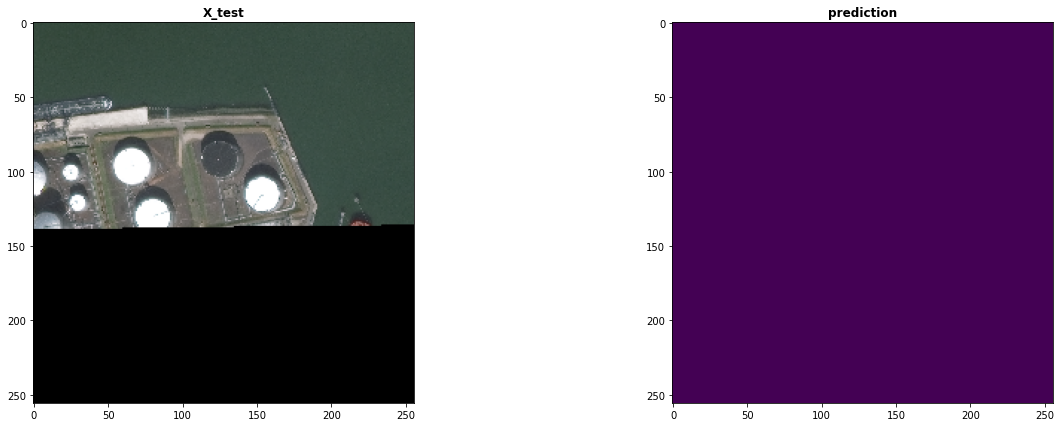

In [ ]:
# Perform a sanity check on some random test samples
ix = np.random.randint(0, len(preds_test_t))
print("index: {}".format(ix))
print("Test set")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(21,7))
show(reshape_as_raster(X_test[ix]), ax=ax1, title='X_test')
show(reshape_as_raster(preds_test_t[ix]), ax=ax2, title='prediction')
plt.show()

# TRIAL

In [ ]:
X_train[0].shape


preds_train = model.predict(X_train[:10], verbose=1)
# preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_train[0].shape
preds_train[0]

1/1 [==============================] - 0s 2ms/step


array([[[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       ...,

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 900, 900)
(4, 900, 900)


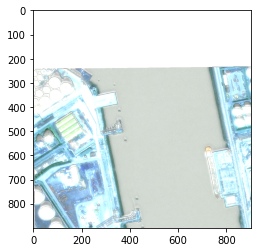

In [ ]:
h = rasterio.open('/content/gdrive/My Drive/Colab Notebooks/spacenet6_data/SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190804111224_20190804111453_tile_8679.tif').read()
print(h.shape)
hh = reshape_as_image(h)
print(h.shape)
h
show(h)

In [ ]:
pix = np.array(Image.open('/content/gdrive/My Drive/Colab Notebooks/spacenet6_data/cell.png'))
pix.shape

(256, 320)

In [ ]:
asd = rasterio.open(PATH_LABEL/label_ids[0]).read()
save_np_2d(asd[0], 'asd')

saved


In [ ]:
img = rasterio.open(PATH_LABEL/label_ids[0]).read()
img = reshape_as_image(img)
img = tf.image.resize(img, [128,128], preserve_aspect_ratio=True, method='nearest')
img = tf.dtypes.cast(img, tf.uint8)
img = img.numpy()
img = reshape_as_raster(img)
save_np_2d(img[0], 'img')

saved


In [ ]:
img = rasterio.open(PATH_TRAIN_PSRBG/id).read()
img = reshape_as_image(img)
img = tf.image.resize(img, [128,128], preserve_aspect_ratio=True, method='nearest')
img = tf.dtypes.cast(img, tf.uint8)
img = img.numpy()
img = reshape_as_raster(img)
save_np_2d(img[0], 'img1')
save_np_2d(img[1], 'img2')
save_np_2d(img[2], 'img3')

saved
saved
saved
